In [1]:
import warnings
import numpy as np
import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    PrecisionRecallDisplay,
    log_loss,
    RocCurveDisplay
)

from intent_model.preprocessing.targets import rh_vs_rest_target
from intent_model.functions import get_conversions, get_optimal_threshold

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_parquet('data/dataset_v2.5/dataset.pq')

In [4]:
data.columns

Index(['valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
       'service_area_id', 'country_name', 'latitude', 'longitude',
       'is_trip_ended', 'num_trips', 'quantile', 'trx_amt', 'rh',
       'min_dist_to_known_loc', 'known_loc_occ', 'is_freq',
       'dist_to_most_freq', 'weekday', 'minutes_sin', 'minutes_cos', 'rh_frac',
       'norm_week', 'norm_hour'],
      dtype='object')

In [5]:
data.head()

,valid_date,ts,sessionuuid,customer_id,booking_id,service_area_id,country_name,latitude,longitude,is_trip_ended,...,min_dist_to_known_loc,known_loc_occ,is_freq,dist_to_most_freq,weekday,minutes_sin,minutes_cos,rh_frac,norm_week,norm_hour
0,2023-08-29,2023-08-29 06:20:41,c5c08061-bc59-4395-881b-40c4ecedab86,50268594,1805104352,1,United Arab Emirates,25.227,55.392,1,...,0.000000,1.000000,1,0.000000,1,0.996195,-0.087156,1.000000,0.430331,0.433555
1,2023-09-02,2023-09-02 23:23:41,00000B4E-841D-4427-AB7F-B89078F378C3,52364344,1807582034,1,United Arab Emirates,25.122,55.228,1,...,0.000000,0.609756,1,0.000000,5,-0.160743,0.986996,0.968504,0.330830,0.223265
2,2023-08-29,2023-08-29 08:15:35,efc5d50b-8d1c-489f-b95f-1c808ee6e3b1,10111973,1805129022,1,United Arab Emirates,25.149,55.212,1,...,0.013038,0.800000,1,0.013038,1,0.831470,-0.555570,0.795455,0.137649,0.545455
3,2023-09-06,2023-09-06 16:42:17,00000E5C-36DC-4EBC-90E8-26B23C822D04,6407012,1809507103,1,United Arab Emirates,25.194,55.289,1,...,0.033000,0.846154,1,0.033000,2,-0.942641,-0.333807,0.866667,0.000000,0.208514
4,2023-08-29,2023-08-29 09:24:04,EBF30DF7-B585-4C93-92EF-2147694C9B6F,39224751,0,1,United Arab Emirates,25.123,55.401,0,...,0.000000,0.051724,0,0.098494,1,0.629320,-0.777146,0.537037,0.487088,0.325396


In [6]:
data = rh_vs_rest_target(data)

In [7]:
data.target.value_counts()

1    1467341
0     532392
Name: target, dtype: int64

### Model

In [8]:
MODEL_PATH = 'cb_models/binary_time.cbm'

model = cb.CatBoostClassifier().load_model(MODEL_PATH)

In [9]:
cb_test = data[model.feature_names_]
cb_test_y = data.target.values

In [10]:
ppreds = model.predict_proba(cb_test)
preds = model.predict(cb_test)

In [11]:
log_loss(cb_test_y, ppreds)

0.40533133657669446

In [12]:
roc_auc_score(cb_test_y, ppreds[:, 1])

0.8750775559430573

In [13]:
print(classification_report(cb_test_y, preds))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68    532392
           1       0.90      0.84      0.87   1467341

    accuracy                           0.82   1999733
   macro avg       0.77      0.79      0.78   1999733
weighted avg       0.83      0.82      0.82   1999733



In [14]:
target_thresh, expected_recall = get_optimal_threshold(cb_test_y, ppreds[:, 1], 0.9)

print(expected_recall)
print(target_thresh)

0.8421321287962376
0.49881581496713445


In [15]:
print(classification_report(cb_test_y, np.where(ppreds[:, 1] > target_thresh, 1, 0)))

              precision    recall  f1-score   support

           0       0.63      0.74      0.68    532392
           1       0.90      0.84      0.87   1467341

    accuracy                           0.82   1999733
   macro avg       0.77      0.79      0.78   1999733
weighted avg       0.83      0.82      0.82   1999733



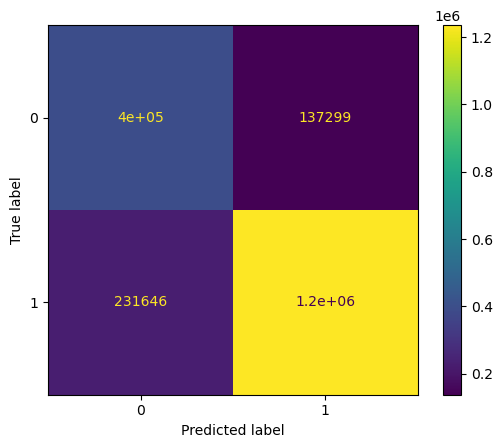

In [16]:
threshold = target_thresh  # 0.5

cm = confusion_matrix(cb_test_y, np.where(ppreds[:, 1] > threshold, 1, 0))
cm_display = ConfusionMatrixDisplay(cm).plot()

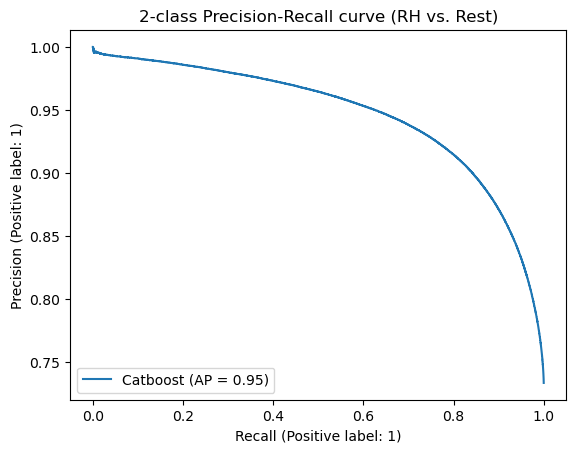

In [17]:
display = PrecisionRecallDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("2-class Precision-Recall curve (RH vs. Rest)")

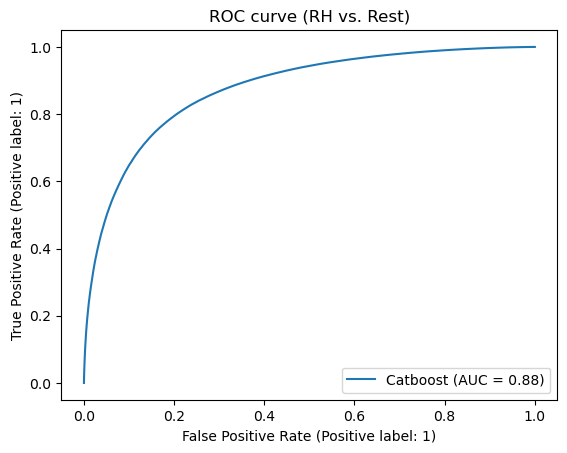

In [18]:
display = RocCurveDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("ROC curve (RH vs. Rest)")

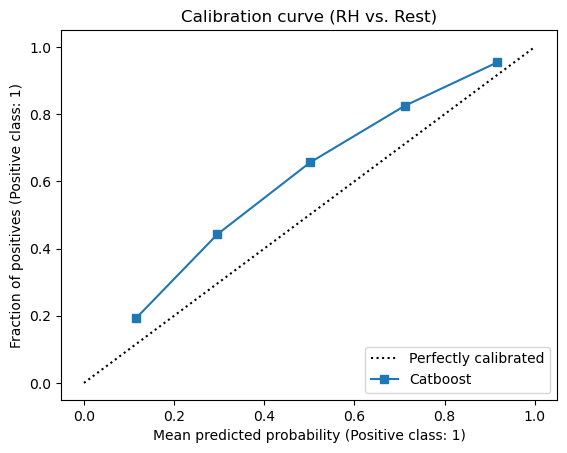

In [19]:
display = CalibrationDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("Calibration curve (RH vs. Rest)")

In [20]:
get_conversions(data, cb_test, model)

100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.13it/s]


,threshold,sa_coverage,rh_coverage,relevance
0,0.4,0.743480,0.889268,0.593397
1,0.5,0.685882,0.841519,0.616276
2,0.6,0.626165,0.784373,0.637721
3,0.7,0.556084,0.709702,0.661623
4,0.8,0.458346,0.595789,0.696975
5,0.9,0.291164,0.386538,0.776516
